# Plot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math as m
import mplstereonet
import pandas as pd
%matplotlib inline


In [2]:
def create_base_directory(geometry):
    root = os.getcwd()
    geometry_dir = os.path.join(root, geometry)
    if not os.path.isdir(geometry_dir):
        os.mkdir(geometry_dir)
        return geometry_dir
    else:
        return geometry_dir
    
def calculate_theta_phi(sph):
    df = pd.DataFrame(sph, columns= ['r', 'theta', 'phi'])
    theta = [m.degrees(df['theta'].iloc[i]) for i in range(len(df))]
    phi = [m.degrees(df['phi'].iloc[i]) for i in range(len(df))]
    return theta, phi

# define a function to convert cartesian coord. into spherical coordinates
def cartesian_to_spherical(x, y, z):
    r = m.sqrt(x ** 2 + y ** 2 + z ** 2)  # r
    elev = m.atan2(z, m.sqrt(x ** 2 + y ** 2))  # theta
    az = m.atan2(y, x)  # phi
    return [r, elev, az]

def get_gs_magnetizations(filepath):
    cart = []
    for file in os.listdir(filepath):
        with open(os.path.join(filepath, file), 'r') as f:
            coord = f.readlines()[-1].split(',')
            mx = float(coord[-3])
            my = float(coord[-2])
            mz = float(coord[-1])
        cart.append([mx, my, mz])
    return cart
    
# Equal-Area function
EqualArea = lambda Pl: np.sqrt(2.) * 90. * np.sin(np.radians(90. - Pl) / (2.))
    
def plot_stereonet(sph, size, filename):
    theta, phi = calculate_theta_phi(sph)[0], calculate_theta_phi(sph)[1]
    fig, ax = mplstereonet.subplots()
    for i in range(len(theta)):
        if theta[i] >= 0:
            ax.rake(phi[i] - 90, theta[i], -90, color='k', marker='.', markersize=12)
        else:
            theta[i] = np.pi - theta[i]
            ax.rake(phi[i] - 90, theta[i], -90, color='k', marker='.', markersize=12, mfc='white')
        ax.grid(linestyle='--')
    plt.savefig(filename + '_stereonet.png', dpi = 300)
    plt.close(fig) 

def plot_planes(sph, size, filename):
    theta, phi = calculate_theta_phi(sph)[0], calculate_theta_phi(sph)[1]
    fig, ax = mplstereonet.subplots()
    for i in range(len(theta)):
        if theta[i] >= 0:
            ax.plane(phi[i] - 90, theta[i], -90)
        else:
            theta[i] = np.pi - theta[i]
            ax.plane(phi[i] - 90, theta[i], -90)
        ax.grid(linestyle='--')
    plt.savefig(filename + '_planes.png', dpi = 300)
    plt.close(fig) 
    
def plot_stereo_and_planes(sph, size, filename):
    theta, phi = calculate_theta_phi(sph)[0], calculate_theta_phi(sph)[1]
    fig, ax = mplstereonet.subplots()
    for i in range(len(theta)):
        if theta[i] >= 0:
            ax.rake(phi[i] - 90, theta[i], -90, color='k', marker='.', markersize=12)
            ax.plane(phi[i] - 90, theta[i], -90)
        else:
            theta[i] = np.pi - theta[i]
            ax.plane(phi[i] - 90, theta[i], -90)
            ax.rake(phi[i] - 90, theta[i], -90, color='k', marker='.', markersize=12, mfc='white')
        ax.grid(linestyle='--')
    plt.savefig(filename + '_both.png', dpi = 300)
    plt.close(fig) 
    
def plot_stereonets(geometry, N_holes, Ts, sizes, R_holes):
    base = create_base_directory(geometry)
    for N_hole in N_holes:
        for T in Ts:
            for size in sizes:
                hyst_gss_path = os.path.join(base,
                                          '{0:g}_holes_R{1:g}'.format(N_hole, R_holes*1000),
                                          'T{0:g}'.format(T),
                                          'hysteresis',
                                          'groundstates',
                                          str(size))
                cart = get_gs_magnetizations(hyst_gss_path)
                sph = [cartesian_to_spherical(i[0], i[1], i[2]) for i in cart]
                plot_dir_path = os.path.join(base,
                                          '{0:g}_holes_R{1:g}'.format(N_hole, R_holes*1000),
                                          'T{0:g}'.format(T),
                                          'plots',
                                          'stereonet')
                if not os.path.isdir(plot_dir_path):
                    os.mkdir(plot_dir_path)
                filename = os.path.join(plot_dir_path, 
                                       's{0:g}_N{1:g}_T{2:g}_R{3:g}'.format(size,
                                                                           N_hole,
                                                                           T,
                                                                           R_holes*1000))
                plot_stereonet(sph, size, filename)     
                plot_planes(sph, size, filename)
                plot_stereo_and_planes(sph, size, filename)
                    

def plot_hysteresis_loops(geometry, N_holes, Ts, sizes, R_holes):
    base = create_base_directory(geometry)
    for N_hole in N_holes:
        for T in Ts:
            for size in sizes:
                hyst_loops_path = os.path.join(base,
                                          '{0:g}_holes_R{1:g}'.format(N_hole, R_holes*1000),
                                          'T{0:g}'.format(T),
                                          'hysteresis',
                                          'loops',
                                          str(size))
                for file in os.listdir(hyst_loops_path):
                    if os.path.splitext(file)[1] == '.hyst':
                        filename = os.path.splitext(file)[0]
                        x = int(filename.split('_')[4])
                        y = int(filename.split('_')[5])
                        z = int(filename.split('_')[6])
                        df = pd.read_csv(os.path.join(hyst_loops_path, file), header = 1)
                        plt.plot(df[df.columns[0]], df[df.columns[2]], color = 'tab:blue')
                        plt.plot(-df[df.columns[0]], -df[df.columns[2]], color = 'tab:blue')
                        plt.xlabel('Magnetic Field (mT)')
                        plt.xlabel('Normalized magnetic moment')
                        plt.grid(True, linestyle = '--')
                        plot_hyst_loops_path = os.path.join(base,
                                          '{0:g}_holes_R{1:g}'.format(N_hole, R_holes*1000),
                                          'T{0:g}'.format(T),
                                          'plots',
                                          'hysteresis_loops')
                        if not os.path.isdir(plot_hyst_loops_path):
                            os.mkdir(plot_hyst_loops_path)
                        filename = os.path.join(plot_hyst_loops_path, 
                                       's{0:g}_N{1:g}_T{2:g}_R{3:g}_{4:g}_{5:g}_{6:g}'.format(size,
                                                                           N_hole,
                                                                           T,
                                                                           R_holes*1000,
                                                                           x,
                                                                           y,
                                                                           z))
                        plt.savefig(filename + '.png', dpi = 300)
                        plt.clf() 
                    
                        
     

In [3]:
geometry = "cubic_1"

N_holes = [0, 5]
Ts = [20] 
sizes = np.arange(10, 50, 10)
R_holes = [0.001, 0.002]

KeyboardInterrupt: 

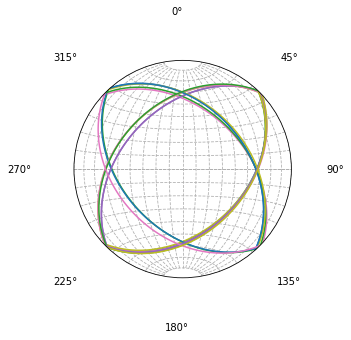

In [135]:
for r in R_holes:
    plot_stereonets(geometry, N_holes, Ts, sizes, r)

In [244]:
for r in R_holes:
    plot_hysteresis_loops(geometry, N_holes, Ts, sizes, r)

<Figure size 432x288 with 0 Axes>